In [1]:
import sys
sys.path.append("/fs/clip-controllablemt/IWSLT2022/scripts")

In [2]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer
)
import torch

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [4]:
def read_file(fname, n=None):
    data = []
    i = 0
    with open(fname) as f:
        for line in f:
            data.append(line.strip())
            i+=1
            if n is not None and i > n:
                break
    return data

def read_scores(fname):
    data = []
    with open(fname) as f:
        for line in f:
            data.append(float(line.strip()))
    return data

def get_data(tgt_lang, domain, split):
    source = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.en")
    formal_translations = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.formal.{tgt_lang}")
    informal_translations = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.informal.{tgt_lang}")
    return source, formal_translations, informal_translations

In [5]:
cache_dir="/fs/clip-scratch/sweagraw/CACHE"

In [6]:
def get_model(model_dir, is_regression=False):
    if is_regression:
        num_labels=1
    else:
        num_labels=2

    config = AutoConfig.from_pretrained(
            model_dir,
            num_labels=num_labels,
            cache_dir=cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_dir,
        from_tf=bool(".ckpt" in model_dir),
        config=config,
        cache_dir=cache_dir)
    return model, tokenizer

In [7]:
def classify(text):
    model_inputs = tokenizer(text, return_tensors="pt",truncation=True, padding=True, max_length=200)
    logits=model(**model_inputs).logits
    return torch.softmax(logits, dim=1).tolist()[0]

# Test example

In [ ]:
source, formal_translations, informal_translations = get_data("hi", "combined", "train")

In [ ]:
model, tokenizer = get_model("/fs/clip-controllablemt/IWSLT2022/models/xformal-classifier")

In [ ]:
classify(source[0])

# Plot scores

In [ ]:
scores_dict = {}
for dir_name in glob.glob("../internal_split/*"):
    scores_dict[dir_name.split("/")[-1]] = {}
    for file_name in glob.glob(dir_name + "/*"):
        if file_name.endswith(".scores") and "combined" in file_name:
            scores_dict[dir_name.split("/")[-1]][file_name.split("/")[-1]] = read_scores(file_name)

In [ ]:
# source formality train and dev
import numpy as np

def get_accuracy(scores_formal, scores_informal, classify=True, threshold=0.5):
    if classify:
        print("Formal", sum(np.array(scores_formal) < threshold)/ len(scores_formal))
        print("InFormal", sum(np.array(scores_informal) > threshold)/ len(scores_informal))
    else:
        print("Formal", sum(np.array(scores_formal) > threshold)/ len(scores_formal))
        print("InFormal", sum(np.array(scores_informal) < threshold)/ len(scores_informal))

def plot_scores(lang):
    src, tgt = lang.split("-")
    scores_src = scores_dict[lang]['dev.combined.' + src + '.scores']
    scores_formal = scores_dict[lang]['dev.combined.formal.' + tgt + '.scores']
    scores_informal = scores_dict[lang]['dev.combined.informal.' + tgt + '.scores']  
    get_accuracy(scores_formal, scores_informal)
    sns.histplot([1-x for x in scores_informal])
    plt.show()
    sns.histplot(scores_informal)
    plt.show()

In [ ]:
for lang in ["en-de", "en-ja", "en-hi", "en-es"]:
    plot_scores('en-de')

# Evaluate formality classifiers

In [ ]:
formal = read_file("../../synthetic/es_en_formal.tsv", n=1500)
informal = read_file("../../synthetic/es_en_informal.tsv", n=1500)

In [ ]:
model, tokenizer = get_model("/fs/clip-controllablemt/IWSLT2022/models/xformal-classifir-es")

In [ ]:
formal_labels = []
for f in formal:
#     print(f)
    formal_labels.append(classify(f))

In [ ]:
informal_labels = []
for f in informal:
    informal_labels.append(classify(f))

In [ ]:
import seaborn as sns
import numpy as np
sns.histplot((1-np.array(formal_labels))[:, 0])

In [ ]:
sns.histplot(np.array(informal_labels)[:, 0])

# Generate scores for Mining

In [ ]:
df = pd.read_csv('../../jparacrawl/en-ja/en-ja.bicleaner05.txt', sep="\t", names=["prov", "score", "src", "tgt"], nrows=50000)

In [ ]:
model, tokenizer = get_model("/fs/clip-controllablemt/IWSLT2022/models/xformal-classifier-ja")

In [ ]:
df["formality_score"] = df["tgt"].progress_apply(classify)

In [ ]:
df.head()

In [ ]:
df.to_csv('en-ja.bicleaner05_50K_formality.txt')

In [ ]:
df = pd.read_csv('en-ja.bicleaner05_50K_formality.txt')

In [ ]:
df.head()

In [ ]:
df["p(informal)"] = df["formality_score"].apply(lambda x: x[0])

In [ ]:
sns.histplot(df["p(informal)"])

In [ ]:
model, tokenizer = get_model("/fs/clip-controllablemt/IWSLT2022/models/xformal-classifier-hi")

In [ ]:
# hi
data = read_file("../../CCMatrix/en-hi/CCMatrix.en-hi.hi", n=100000)

In [ ]:
with open("../../CCMatrix/en-hi/CCMatrix.en-hi.hi.50k.2.scores", "w") as f:
    for line in tqdm(data[50000:]):
        f.write(str(classify(model, tokenizer, line)[0]) + "\n")

In [20]:
scores_hi = read_scores("../../mined_bitext/CCMatrix/en-hi/CCMatrix.en-hi.hi.50k.scores")

<AxesSubplot:ylabel='Count'>

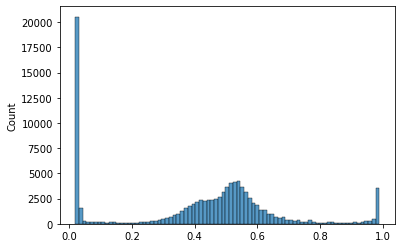

In [21]:
sns.histplot(scores_hi)

In [ ]:
import numpy as np
len(np.array(scores_hi)[np.array(scores_hi) > 0.7])

In [8]:
df = pd.read_csv('../../mined_bitext/paracrawl/v8/paracrawl-release8.en-ru.bifixed.v0.14.dedup.filter-1.1', sep="\t", names=["src", "tgt", "bicleaner", "laser"], nrows=100000)

In [9]:
df.head()

,src,tgt,bicleaner,laser
0,Popular categories,Популярные категории,0,1.125711
1,Other free porn sites,Другие бесплатные порносайты,0.760,1.158605
2,Monster,Монстр,0,1.107334
3,Sorry. No matches found.,Извините. Ничего не найдено.,0.680,1.157635
4,Farm,Ферма,0,1.108173


In [10]:
model, tokenizer = get_model("/fs/clip-controllablemt/IWSLT2022/models/xformal-classifier-ru")

In [ ]:
df["formality_score"] = df["tgt"].progress_apply(classify)

 27%|████████████████████▏                                                     | 27250/100000 [21:27<1:15:58, 15.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 68%|███████████████████████████████████████████████████▎                        | 67590/100000 [53:53<28:41, 18.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
df.to_csv('en-ru.100K_formality_russian')

In [3]:
df = pd.read_csv('en-ru.100K_formality_russian')

In [4]:
df["P(informal)"] = df["formality_score"].apply(lambda x: float(x.split(",")[0][1:]))

In [5]:
df.head()

,Unnamed: 0,src,tgt,bicleaner,laser,formality_score,P(informal)
0,0,Popular categories,Популярные категории,0,1.125711,"[0.9812387228012085, 0.018761318176984787]",0.981239
1,1,Other free porn sites,Другие бесплатные порносайты,0.760,1.158605,"[0.9955869913101196, 0.004413031041622162]",0.995587
2,2,Monster,Монстр,0,1.107334,"[0.9595021605491638, 0.04049782082438469]",0.959502
3,3,Sorry. No matches found.,Извините. Ничего не найдено.,0.680,1.157635,"[0.9930434226989746, 0.0069565544836223125]",0.993043
4,4,Farm,Ферма,0,1.108173,"[0.8574844002723694, 0.14251555502414703]",0.857484


<AxesSubplot:xlabel='P(informal)', ylabel='Count'>

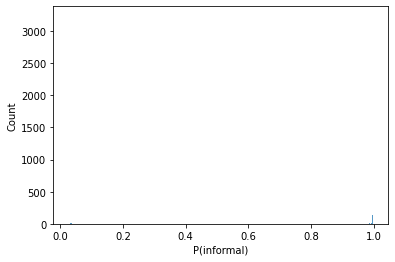

In [7]:
sns.histplot(df["P(informal)"])

In [ ]:
import pandas as pd

df = pd.read_csv("en-ru.100K_formality", index_col=0)

In [ ]:
df["bicleaner"]

In [ ]:
df["laser"].plot()

In [ ]:
df["P(informal)"] = df["formality_score"].apply(lambda x: float(x.split(",")[0][1:]))

In [ ]:
df.head()

In [ ]:
formal_df = df.sort_values("P(informal)").head(100000)

In [ ]:
informal_df = df.sort_values("P(informal)", ascending=False).head(50000)

In [ ]:
formal_df["rule"] = formal_df["tgt"].apply(lambda x: "Вы" in x)

In [ ]:
formal_subset_df= formal_df[(formal_df["rule"]==True) & (formal_df["laser"].astype(float) > 1.2)]

In [ ]:
informal_df["rule"] = informal_df["tgt"].apply(lambda x: "ты" in x)

In [ ]:
informal_subset_df = informal_df[(informal_df["rule"]==True) & (informal_df["laser"].astype(float) > 1.2)]

In [ ]:

def concatenate_lists_into_df(lists, labels):
    lists_with_names = [[labels[i]] + [y] for i in range(len(lists)) for y in lists[i]]
    df = pd.DataFrame(lists_with_names).reset_index() 
    df.columns=["SID", "label", "sentence"]
    return df

In [ ]:
import pandas as pd
all_scores = concatenate_lists_into_df([formal_subset_df["tgt"], informal_subset_df["tgt"]], ['1', '0'])

In [ ]:
all_scores

In [ ]:
from sklearn.utils import shuffle
all_scores = shuffle(all_scores)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_scores, test_size=0.2)

In [ ]:
all_df.to_csv("en-ru.rule")

In [ ]:
train.to_csv("../formality_classifiers_data/ru/" + "/train.csv", index=False)

In [ ]:
test.to_csv("../formality_classifiers_data/ru/" + "/dev.csv", index=False)

In [3]:
en = read_file("../../mined_bitext/paracrawl/v8/en-it/ParaCrawl.100k.en-it.en")
it = read_file("../../mined_bitext/paracrawl/v8/en-it/ParaCrawl.100k.en-it.it")
multi_scores = read_file("../paracrawl.en-it.multi.100k.scores")
xformal_scores = read_file("../paracrawl.en-it.xformal.100k.scores")

In [61]:
df = pd.DataFrame([en, it, multi_scores, xformal_scores]).transpose()

In [62]:
df.columns = ["src", "tgt", "multi", "xformal"]

In [63]:
df.head()

,src,tgt,multi,xformal
0,"We provide not only dictionary!Xóõ-Ninam, but ...","Forniamo non solo dizionario!O!ung - Ninam, ma...",0.5246639847755432,0.8750554323196411
1,The Agency works to provide technical support ...,L’Agenzia opera per fornire supporto tecnico a...,0.44010061025619507,0.0013071110006421804
2,Then the researchers of the National Research ...,"Poi, i ricercatori dell’Istituto Nazionale del...",0.5046135783195496,0.0012979418970644474
3,Both men and women need to do resistance and p...,Sia gli uomini e le donne hanno bisogno di far...,0.49218568205833435,0.06983716040849686
4,The opening began,L'apertura è iniziata,0.47368913888931274,0.019087575376033783


In [64]:
def rule_based(text):
    if text:
        if "tu" in text.lower().split(" "):
            return "0"
        elif "voi" in text.lower().split(" ") or "lei" in text.lower().split(" "):
            return "1"
        else:
            return "none"
    else:
        return "none"

In [65]:
df["rule_based"] = df["tgt"].apply(rule_based)

In [66]:
print(df["rule_based"].value_counts())

none    99155
1         548
0         298
Name: rule_based, dtype: int64


In [67]:
sample_df = df[df["rule_based"] != "none"]    

In [68]:
sample_df =sample_df[["tgt","rule_based"]]
df = pd.DataFrame(sample_df).reset_index() 
df.columns=["SID", "sentence", "label"]

In [69]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [70]:
train.to_csv("../formality_classifiers_data/it/" + "/train.csv", index=False)
test.to_csv("../formality_classifiers_data/it/" + "/dev.csv", index=False)

# Paired Vs Unpaired

In [8]:
model, tokenizer = get_model("/fs/clip-controllablemt/IWSLT2022/models/xformal-classifier-it")

In [9]:
formal_scores =  [classify(x)[0] for x in open("../../formality-control_UMD/EN-IT/unconstrained/formality/blind-test/formality-control-1.formal.it").readlines()]

In [10]:
informal_scores =  [classify(x)[0] for x in open("../../formality-control_UMD/EN-IT/unconstrained/formality/blind-test/formality-control-1.informal.it").readlines()]

<AxesSubplot:ylabel='Count'>

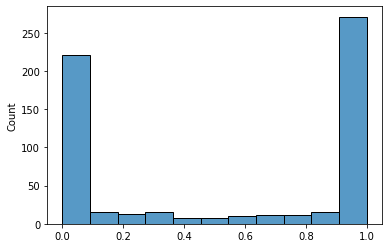

In [11]:
sns.histplot(informal_scores)

<AxesSubplot:ylabel='Count'>

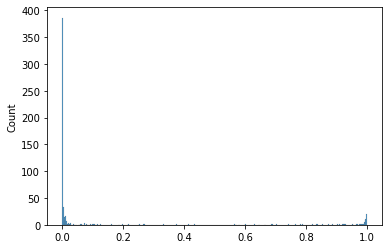

In [12]:
sns.histplot(formal_scores)

In [ ]:
formal_scores =  read_scores("../../formality-control_UMD/EN-ES/unconstrained/formality/blind-test/formality-control-4.formal.es")

In [ ]:
unpaired_scores_dict = {}
for fname in glob.glob("../../model_outputs/finetuned_paired_res/*.scores"):
    unpaired_scores_dict[fname.split("/")[-1]] = read_scores(fname)

In [ ]:
paired_scores_dict = {}
for fname in glob.glob("../../model_outputs/finetuned_unpaired_res/*.scores"):
    paired_scores_dict[fname.split("/")[-1]] = read_scores(fname)

In [ ]:
for key in unpaired_scores_dict:
    if "combined" in key:
        if key in unpaired_scores_dict and key in paired_scores_dict:
            print(key)
            sns.histplot(unpaired_scores_dict[key])
            print("Unpaired (mean)", np.mean(unpaired_scores_dict[key]))
            print("Unpaired (std)", np.std(unpaired_scores_dict[key]))
            plt.show()
            sns.histplot(paired_scores_dict[key])
            print("Paired (mean)", np.mean(paired_scores_dict[key]))
            print("Paired (std)", np.std(paired_scores_dict[key]))
            plt.show()

In [ ]:
finetuned_scores_dict = {}
for fname in glob.glob("../../model_outputs/finetuned-res/*.scores"):
    finetuned_scores_dict[fname.split("/")[-1]] = read_scores(fname)

In [ ]:
pretrained_scores_dict = {}
for fname in glob.glob("../../model_outputs/pretrained-res/*.scores"):
    pretrained_scores_dict[fname.split("/")[-1]] = read_scores(fname)

In [ ]:
for key in finetuned_scores_dict:
    if "combined" in key:
        if key in finetuned_scores_dict and key in pretrained_scores_dict:
            print(key)
            sns.histplot(finetuned_scores_dict[key])
            print("Finetuned (mean)", np.mean(finetuned_scores_dict[key]))
            print("Finetuned (std)", np.std(finetuned_scores_dict[key]))
            plt.show()
            sns.histplot(paired_scores_dict[key])
            print("Pre-trained (mean)", np.mean(pretrained_scores_dict[key]))
            print("Pre-trained (std)", np.std(pretrained_scores_dict[key]))
            plt.show()